In [95]:
import os
from tqdm import tqdm 
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# DATA 

In [96]:
stops=pd.read_csv('/kaggle/input/stops-tesi/stops.csv')
stops = stops[
    (stops['LATITUDE'] >= 49.9) & (stops['LATITUDE'] <= 55.8) &
    (stops['LONGITUDE'] >= -6.4) & (stops['LONGITUDE'] <= 1.8) & (stops['DURATION']>2)
]

ports=pd.read_csv('/kaggle/input/tutti-i-porti/PORTS.csv')
ports = ports[
    (ports['LATITUDE'] >= 49.9) & (ports['LATITUDE'] <= 55.8) &
    (ports['LONGITUDE'] >= -6.4) & (ports['LONGITUDE'] <= 1.8)
]

# Funzioni

In [97]:
from sklearn.cluster import DBSCAN
import pandas as pd

def dbscan_clustering(stops, eps, min_samples):
    
    
    # Seleziona le colonne delle coordinate
    X = stops[['LONGITUDE', 'LATITUDE']].copy()
    
    # Esegui DBSCAN con i parametri forniti
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    
    # Aggiungi il cluster ottenuto al DataFrame 'stops'
    stops['cluster'] = clusters
    
    # Trova il centroide per ogni cluster escludendo il rumore (cluster -1)
    centroids = stops[stops['cluster'] != -1].groupby('cluster')[['LONGITUDE', 'LATITUDE']].mean().reset_index()
    centroids.rename(columns={'LONGITUDE': 'CENTROID_LONGITUDE', 'LATITUDE': 'CENTROID_LATITUDE'}, inplace=True)
    
    return centroids

from geopy.distance import geodesic
def calculate_precision_recall_f1(centroids, ports, max_distance_nautical_miles=10):
    """
    Calcola la precisione, il richiamo e l'F1-score per i centroidi dei cluster rispetto ai porti sulla base della distanza.

    Parametri:
    - centroids: DataFrame contenente i centroidi dei cluster con colonne 'CENTROID_LONGITUDE' e 'CENTROID_LATITUDE'.
    - ports: DataFrame contenente i dati dei porti con colonne 'LONGITUDE' e 'LATITUDE'.
    - max_distance_nautical_miles: La distanza massima in miglia nautiche per considerare un centroide vicino a un porto.

    Restituisce:
    - precision: Precisione calcolata come TP / (TP + FP).
    - recall: Richiamo calcolato come TP / (TP + FN).
    - f1_score: F1-score calcolato come 2 * (precision * recall) / (precision + recall).
    - tp_clusters: Lista dei cluster considerati True Positives.
    - fp_clusters: Lista dei cluster considerati False Positives.
    - fn_ports: Lista dei porti considerati False Negatives.
    - total_clusters: Numero totale di cluster analizzati.
    """
    # Soglia massima distanza in miglia nautiche (10 miglia nautiche corrispondono a circa 18.52 km)
    max_distance_km = max_distance_nautical_miles * 1.852  # Conversione da miglia nautiche a chilometri
    
    # Liste per salvare TP, FP e FN
    tp_clusters = []
    fp_clusters = []
    fn_ports = []
    
    # Funzione per calcolare la distanza tra due coordinate in km
    def distance_in_km(coord1, coord2):
        return geodesic(coord1, coord2).km

    # Verifica ogni centroide se ha un porto vicino entro 10 miglia nautiche (Precisione)
    for i, centroid in centroids.iterrows():
        cluster_coord = (centroid['CENTROID_LATITUDE'], centroid['CENTROID_LONGITUDE'])
        close_to_port = False
        
        # Controlla la distanza tra il centroide del cluster e ciascun porto
        for _, port in ports.iterrows():
            port_coord = (port['LATITUDE'], port['LONGITUDE'])
            distance = distance_in_km(cluster_coord, port_coord)
            
            if distance <= max_distance_km:
                close_to_port = True
                break
        
        if close_to_port:
            tp_clusters.append(centroid['cluster'])  # Aggiungi cluster ai True Positives
        else:
            fp_clusters.append(centroid['cluster'])  # Aggiungi cluster ai False Positives

    # Verifica ogni porto se ha un centroide vicino entro 10 miglia nautiche (Recall)
    for i, port in ports.iterrows():
        port_coord = (port['LATITUDE'], port['LONGITUDE'])
        close_to_cluster = False
        
        # Controlla la distanza tra il porto e ciascun centroide
        for _, centroid in centroids.iterrows():
            cluster_coord = (centroid['CENTROID_LATITUDE'], centroid['CENTROID_LONGITUDE'])
            distance = distance_in_km(port_coord, cluster_coord)
            
            if distance <= max_distance_km:
                close_to_cluster = True
                break
        
        if not close_to_cluster:
            fn_ports.append(port['PORT_CODE'])  # Aggiungi porto ai False Negatives

    # Calcola Precision e Recall
    tp = len(tp_clusters)
    fp = len(fp_clusters)
    fn = len(fn_ports)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calcola F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    total_clusters = tp + fp

    return precision, recall, f1_score, total_clusters


# Grid search

In [100]:
results = []
for e in tqdm(np.arange(0.000001, 0.001, 0.00005)):
    for m in range(2, 5, 1):
        centroids = dbscan_clustering(stops, eps=e, min_samples=m)
        precision, recall, f1_score, total_clusters = calculate_precision_recall_f1(centroids, ports)
        
        # Aggiungi i risultati attuali alla lista
        results.append({
            'eps': e,
            'min_samples': m,
            'f1_score': f1_score,
            'total_clusters': total_clusters 
        })
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/grid_search_parameters.csv')

100%|██████████| 20/20 [21:47<00:00, 65.37s/it]


# Heatmap

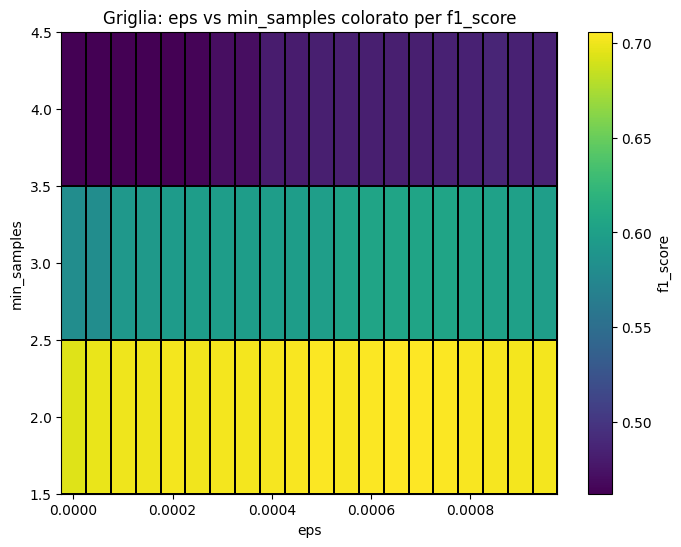

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Supponiamo che 'eps', 'min_samples', e 'f1_score' siano colonne di results_df
x = results_df['eps'].values
y = results_df['min_samples'].values
z = results_df['f1_score'].values

# Crea una griglia 2D da x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Crea una matrice 2D per i valori di z (f1_score) corrispondente alla griglia
Z = np.zeros_like(X, dtype=float)

for i in range(len(x)):
    xi = np.where(np.unique(x) == x[i])[0]
    yi = np.where(np.unique(y) == y[i])[0]
    Z[yi, xi] = z[i]

# Crea la figura
plt.figure(figsize=(8, 6))

# Crea il grafico con i quadrati usando 'pcolormesh' e la palette 'viridis'
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', edgecolor='k', linewidth=0.2)

# Aggiungi la colorbar
plt.colorbar(label='f1_score')

# Aggiungi titolo e etichette
plt.title('Griglia: eps vs min_samples colorato per f1_score')
plt.xlabel('eps')
plt.ylabel('min_samples')

# Mostra il grafico
plt.show()


# Estrai i migliori parametri 

In [27]:
highest_recall_row = results_df.loc[results_df['f1_score'].idxmax()]
centroids = dbscan_clustering(stops, eps=highest_recall_row['eps'], min_samples=int(np.round(highest_recall_row['min_samples'])))
coordinates =centroids[['CENTROID_LONGITUDE', 'CENTROID_LATITUDE']]

# Standardizza i dati
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

# Crea e applica l'algoritmo DBSCAN
db = DBSCAN(eps=0.1, min_samples=1).fit(scaled_coordinates)

# Aggiungi i cluster al DataFrame
centroids['cluster'] = db.labels_

# Trova i cluster unici
clusters = centroids['cluster'].unique()

# Campiona un punto per ogni cluster
centroids = centroids.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)

centroids.to_csv('/kaggle/working/best_centroids.csv')

/tmp/ipykernel_36/2960279280.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  centroids = centroids.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)


In [28]:
centroids['cluster'].nunique()


30

In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point



centroids.columns
# Convertire il DataFrame in geometrie di punti
geometry = [Point(xy) for xy in zip(centroids['CENTROID_LONGITUDE'], centroids['CENTROID_LATITUDE'])]

# Creare un GeoDataFrame
gdf = gpd.GeoDataFrame(centroids, geometry=geometry)

# Impostare un sistema di riferimento spaziale (SRID), ad esempio WGS84
gdf.crs = "EPSG:4326"

# Esportare come shapefile
gdf.to_file('output_shapefile.shp')

/tmp/ipykernel_36/2086425615.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('output_shapefile.shp')
